### ResNetの実装
ResNetの基本式 $y = F(x) + x$
ここで $F(x)$ は残差関数

$$
\text{Output} = \text{ReLU}(F(x) + x)
$$

In [2]:
import tensorflow as tensorflow
from tensorflow.keras.layers import Input, Conv2D, Activation, Add,BatchNormalization

def residual_block(input_tensor, num_filters,strides=1):
    """
    入力と出力のサイズが変わらない、基本的な残差ブロック
    残差：Residual
    Output = f(Input)+Input
        ここでFは2回の畳み込みとReLU活性化

    Skip Connection
        残差分だけを学習することで、層が深くなっても勾配損失問題を防ぐ
    
    Conv
        畳み込みをすると通常は画面の端っこが削れて小さくなるが、padding='same'を指定して周りに余白をつける
        そうすると入力と出力のサイズが変わらなくなる

    Add()([x,shortcut])
        KerasのFunctional APIの書き方
            ➀足し算マシーン(Addレイヤー)の生成、ここでAddは単純に足し算をするだけなので()の中に複雑な設定が必要ない
            ➁足し算マシーンに[x,shortcut]というリストの形状にして足し算を実行する

    Strides
        畳み込みの移動幅を指定するパラメータ
        1なら通常通り1pxずつ、2なら2pxずつ移動する(1個飛ばし)ので、出力サイズが半分になる

    num_filters
        各num_filterは畳み込み層で検知した特徴マップを持っている
        例えば浅い層のフィルターではエッジ検出、深い層ではより複雑なパターンを検出する
            エッジ：隣り合う画素(ピクセル)が急激に変化している部分
    """
    shortcut = input_tensor

    # 畳み込み一回目
    x = Conv2D(num_filters, (3, 3), padding='same',strides=strides)(input_tensor)
    x= BatchNormalization()(x)
    x = Activation('relu')(x)

    # 畳み込み二回目
    x = Conv2D(num_filters, (3, 3), padding='same')(x)
    x= BatchNormalization()(x)

    if strides > 1 or input_tensor.shape[-1] != num_filters:
        """
        サイズが変わる、またはチャンネル数が変わるとき
        .shape[-1]は最後の要素、つまりchannnel
        """
        shortcut = Conv2D(num_filters, (1, 1), padding='same',strides=strides)(shortcut)
        shortcut = BatchNormalization()(shortcut)

    x = Add()([x, shortcut])
    x = Activation('relu')(x)
    return x

### BatchNormalization()の中身について
> ReLUにそのまま通してしまったら負数の情報が全て0になってしまうので、標準化を行う
> $$ \hat{x} = \frac{x - \mu (\text{平均})}{\sigma (\text{標準偏差})} $$
- 入ってきたデータ（ミニバッチ）に対して**標準化「平均を0,分散を1」**
- データから平均値を引くことで中心を0としている

In [3]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense

def build_simple_resnet(input_shape=(128, 128, 3), num_classes=10):
    """
    ResNetの簡易モデルの作成
        画像分類タスクでは、画像の特徴の身を知りたいので畳み込み層のエンコードしか必要ない
        セグメンテーションは位置情報も必要なのでdecodeも必要になる
        ResNet18の18は層の数、50や152などがある

    Projection(射影)
            ➀入力の特徴マップのサイズを変換する
            ➁フィルター数(channel数)を変更する

    GlobalAveragePooling2D
        Strides=1は画像サイズを変えないまま特徴をしっかり抽出する
        
    """
    inputs = Input(input_shape)
    x = residual_block(inputs, num_filters=64, strides=1)

    x = residual_block(x, num_filters=64, strides=1)   #サイズを変えないまま特徴をしっかり見極める
    x = residual_block(x, num_filters=64, strides=1) 
    
    x = residual_block(x, num_filters=128, strides=2)   #サイズを半分にする(Projection Block)
    x = residual_block(x, num_filters=128, strides=1) 
    
    # --- 出口 (Output Layers) ---
    x = GlobalAveragePooling2D()(x) 
    
    # 最終判定 (10クラス分類)
    outputs = Dense(num_classes, activation='softmax')(x)
    
    return Model(inputs, outputs)

### 1. GlobalAveragePooling2D　(GAP)
**位置情報は捨てて、特徴の強さだけを残す層**
> 一枚の特徴マップの全画素の平均を計算して、有効な数字であればその特徴が存在すると考える
  - 入力: $(Batch, 8, 8, 128)$ → 高さ8, 幅8, チャンネル128
  - 出力: $(Batch, 128)$ → 長さ128のベクトル

### 2. Dense （全結合層）
  - 最後のDense層のユニット数は、**分類したいクラス数**（EuroSATなら10個）と一致させる
  - 最後に`Softmax`関数を通すことで、出力を確率（合計すると100%）に変換

In [4]:
# モデルを作成
# input_shapeは、使用する予定の衛星画像サイズに合わせます（仮で64x64としています）
model = build_simple_resnet(input_shape=(64, 64, 3), num_classes=10)

# 設計図を表示
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 64, 64, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 64, 64,    │      1,792 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 64, 64,    │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 64, 64,    │     36,928 │ activation[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │        256 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 64, 64,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 64, 64,    │          0 │ add[0][0]         │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │     36,928 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │     36,928 │ activation_2[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 64, 64,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │ activation_1[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 64, 64,    │          0 │ add_1[0][0]     

 Total params: 717,258 (2.74 MB)

 Trainable params: 715,082 (2.73 MB)

 Non-trainable params: 2,176 (8.50 KB)

In [5]:
import tensorflow_datasets as tfds
import os

# データを保存するディレクトリ (先ほど作った data フォルダを指定)
DATA_DIR = 'data'

"""
tfds.load()でdatasetをダウンロードして読みこむ
    タプルのデータセットとinfoを返す
        eurosatのRGBバージョンを使用する
        as_supervised=True で(画像, ラベル)のタプルで返す
        split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'] で学習・検証・テストに分割

"""
(train_ds, val_ds, test_ds), info = tfds.load(
    'eurosat/rgb',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    data_dir=DATA_DIR,
    as_supervised=True,
    with_info=True
)

print("ダウンロードと読み込みが完了しました！")
print(f"クラス名: {info.features['label'].names}")
print(f"学習データ数: {len(train_ds)}")
print(f"検証データ数: {len(val_ds)}")
print(f"テストデータ数: {len(test_ds)}")

ダウンロードと読み込みが完了しました！
クラス名: ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']
学習データ数: 21600
検証データ数: 2700
テストデータ数: 2700


In [6]:
import tensorflow as tf

# Setting constants
IMG_SIZE = 64
BATCH_SIZE = 32

def preprocess_data(image, label):
    """
    画像データの前処理を行う関数
        1. サイズを確実に合わせる (リサイズ)
            - `tf.image.resize()`はTensorflowのimageモジュールの中にある関数
            - interpolation 補間：いい感じに新しい色を計算して埋める
            > 有限要素法のバイリニア補間
                すべての画素に対して、周囲の整数格子点の値を使って線形補間を行う方法

        2. 正規化 (Normalization)
            - 画像のRGB各チャンネルの値を0から1の範囲にスケーリングする
                - 正規化しないと計算量が膨大になる
        
        .take(n)
            - データセットから最初のn個の要素を取得するメソッド
    """
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE)) # 1.サイズを確実に合わせる(リサイズ)
    image = tf.cast(image, tf.float32) / 255.0 # 2.正規化(Normalization)
    return image, label

# --- パイプラインの構築 ---
AUTOTUNE = tf.data.AUTOTUNE
train_batches = train_ds.map(preprocess_data, num_parallel_calls=AUTOTUNE) \
                        .shuffle(buffer_size=1000) \
                        .batch(BATCH_SIZE) \
                        .prefetch(buffer_size=AUTOTUNE)

val_batches = val_ds.map(preprocess_data, num_parallel_calls=AUTOTUNE) \
                    .batch(BATCH_SIZE) \
                    .prefetch(buffer_size=AUTOTUNE)

# 確認
for img_batch, label_batch in train_batches.take(1):
    print(f"Image Batch Shape: {img_batch.shape}")
    print(f"Label Batch Shape: {label_batch.shape}")

    # Image: (32, 64, 64, 3) -> 32枚, 64x64ピクセル, 3チャンネル(RGB)
    # Label: (32,) -> 32個の正解ラベル

Image Batch Shape: (32, 64, 64, 3)
Label Batch Shape: (32,)


### データパイプライン DataPipeLine
> データパイプラインとは、データをストレージから読み出し、計算モデルが処理可能なテンソルへと変換し、GPUやTPUへ供給する一連の処理工程、およびそれを実装したソフトウェアアーキテクチャを指す。

In [ ]:
# input_shapeは (64, 64, 3), クラス数は 10
model = build_simple_resnet(input_shape=(64, 64, 3), num_classes=10)

# --- コンパイル (学習ルールの設定) ---
model.compile(
    # AIの「間違いの修正方法」を指定します。Adamは最も一般的で優秀な修正担当者です。
    optimizer='adam',    # Optimizer (最適化アルゴリズム): 'adam'

    # Loss (損失関数): 'SparseCategoricalCrossentropy'
    # 正解が整数(0, 1, 2...)の場合は 'Sparse...' を使います。
    # from_logits=True は、AIの生の出力を確率に変換してから計算しろ、という指示です。
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),

    # Metrics (評価指標): 'accuracy'
    metrics=['accuracy']
)

# モデルの設計図確認
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 64, 64, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_12 (Conv2D)  │ (None, 64, 64,    │      1,792 │ input_layer_1[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ conv2d_12[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_10       │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_13 (Conv2D)  │ (None, 64, 64,    │     36,928 │ activation_10[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_14 (Conv2D)  │ (None, 64, 64,    │        256 │ input_layer_1[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ conv2d_13[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ conv2d_14[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_5 (Add)         │ (None, 64, 64,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_11       │ (None, 64, 64,    │          0 │ add_5[0][0]       │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_15 (Conv2D)  │ (None, 64, 64,    │     36,928 │ activation_11[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ conv2d_15[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_12       │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_16 (Conv2D)  │ (None, 64, 64,    │     36,928 │ activation_12[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ conv2d_16[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_6 (Add)         │ (None, 64, 64,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │ activation_11[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_13       │ (None, 64, 64,    │          0 │ add_6[0][0]     

 Total params: 717,258 (2.74 MB)

 Trainable params: 715,082 (2.73 MB)

 Non-trainable params: 2,176 (8.50 KB)

In [8]:
# --- 学習の実行 ---
history = model.fit(
    train_batches,
    validation_data=val_batches,
    epochs=5
)

Epoch 1/5


c:\Users\user\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\backend\tensorflow\nn.py:717: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


675/675 ━━━━━━━━━━━━━━━━━━━━ 1064s 2s/step - accuracy: 0.6689 - loss: 0.9373 - val_accuracy: 0.3926 - val_loss: 4.6740
Epoch 2/5
675/675 ━━━━━━━━━━━━━━━━━━━━ 1082s 2s/step - accuracy: 0.7765 - loss: 0.6405 - val_accuracy: 0.5067 - val_loss: 1.7450
Epoch 3/5
675/675 ━━━━━━━━━━━━━━━━━━━━ 1096s 2s/step - accuracy: 0.8378 - loss: 0.4796 - val_accuracy: 0.6370 - val_loss: 1.9985
Epoch 4/5
675/675 ━━━━━━━━━━━━━━━━━━━━ 1072s 2s/step - accuracy: 0.8656 - loss: 0.3897 - val_accuracy: 0.7067 - val_loss: 0.9175
Epoch 5/5
675/675 ━━━━━━━━━━━━━━━━━━━━ 1102s 2s/step - accuracy: 0.8864 - loss: 0.3371 - val_accuracy: 0.7581 - val_loss: 0.7406


###　Result
> 自分のPCのCPU,Core i7だと90分かかった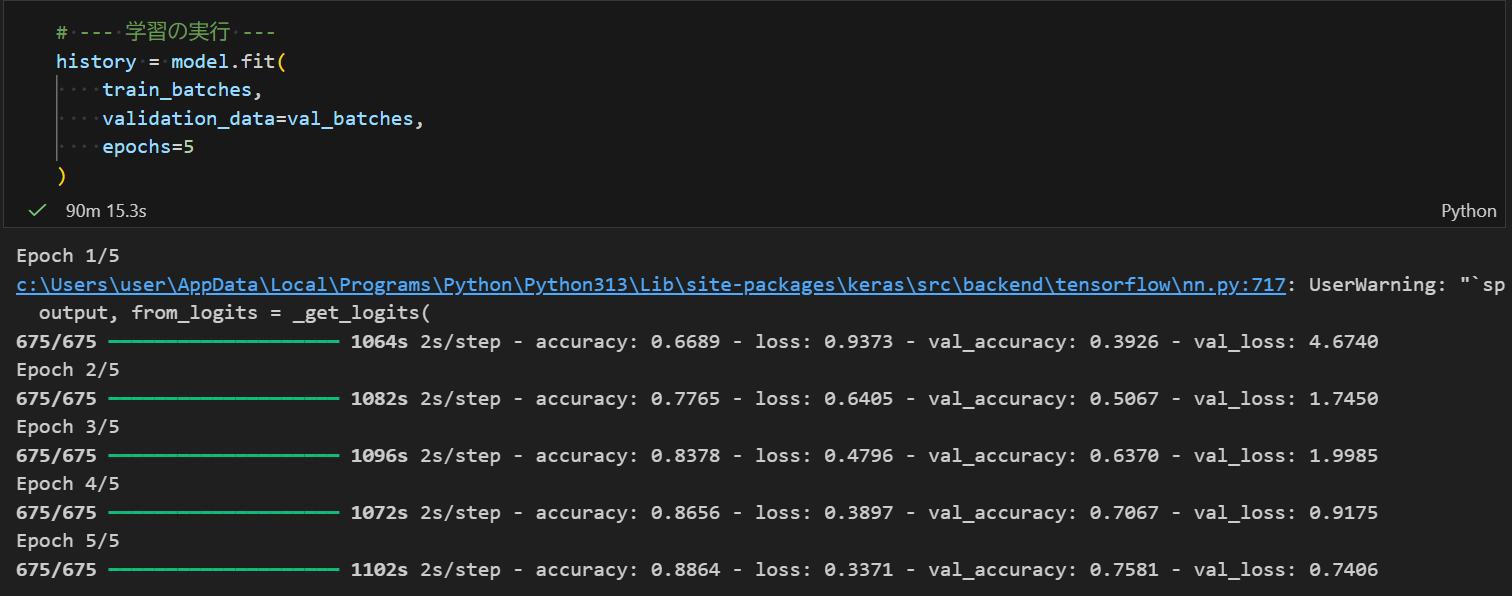